<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Final_project_main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs, imports, Drive mounting

In [0]:
!pip3 install torch torchvision tqdm
!pip3 install pillow==4.1.1

    100% |████████████████████████████████| 591.8MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60b42000 @  0x7f9e0a8e22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.5MB/s 
    100% |████████████████████████████████| 2.0MB 3.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.7MB 7.3MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
import os
import csv
import copy
import glob
from collections import defaultdict

import seaborn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler
from torchvision import models, transforms, utils, datasets

import PIL.Image
def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

assert torch.cuda.is_available()
print(len(glob.glob('/content/gdrive/My Drive/CS 501R/Final Project/*')))

0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
glob.glob('/content/gdrive/My Drive/CS 501R/Final Project/*')

['/content/gdrive/My Drive/CS 501R/Final Project/Score Labeling',
 '/content/gdrive/My Drive/CS 501R/Final Project/Old Exams',
 '/content/gdrive/My Drive/CS 501R/Final Project/Summary of data available.gdoc',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata_finished.csv',
 '/content/gdrive/My Drive/CS 501R/Final Project/Graded Pages',
 '/content/gdrive/My Drive/CS 501R/Final Project/test2.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test100.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test125.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test72.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata.csv',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata_finished.gsheet',
 '/content/gdrive/My Drive/CS 501R/Final Project/score_labels.csv',
 '/content/gdrive/My Drive/CS 501R/Final Project/Architecture and tests.ipynb',
 '/content/gdrive/My Drive/CS 501R/Final Project/best_acc0.8333.pth',
 '/content/gdrive/My Drive/CS 501R/Final Projec

# Helper functions

In [0]:
PARTIAL_BASE = '/content/gdrive/My Drive/CS 501R/Final Project/'

NEW_NAMES = {"W18 Exam 1":"W18_Exam1", "M112 F17 Final Exam":"F17_Final",
                "M112 W18 Final Exam":"W18_Final", "Math112Exam2":"F18_Exam2",
                "M112_Fall_2018_Midterm_1":"F18_Exam1", "F17 Exam2":"F17_Exam2",
                "Exam 2 Winter 2018":"W18_Exam2"}

def display_img(img):
    fig = plt.figure(figsize=(9,12))
    img = img.permute(1,2,0)
    plt.imshow(img.detach())
    plt.show()
    
def new_filename(original_filename):
    s = original_filename.replace(base_filename('Old Exams/'),"").rsplit('/')
    return "Graded Pages/" + NEW_NAMES[s[0]] + "/" + s[-1].replace(".pdf","")

def base_filename(extension=""):
    return '/content/gdrive/My Drive/CS 501R/Final Project/' + extension

def short_filename(filename):
    return filename.replace(base_filename(), "")

def score_labeled_from_stub(fname):
    stub = 'Score Labeling/Score Labeled/' 
    return stub + fname.replace('Graded Pages/','').replace('/','_')

def plot_zip(ax, validations, losses, ylabel, num_epochs=1):
    
    a, b = zip(*validations)
    ax.plot(losses, label='train')
    ax.plot(a, b, label='val')
    #ax.set_xlabel('Batch number')
    ax.set_ylabel(ylabel)
    ax.set_ylim(0,max(1,max(b),max(losses)))
    ax.set_title(ylabel + " over {} epochs".format(num_epochs))
    ax.legend()  
    
def loop_s(epoch, num_epochs, s_loss, s_acc, m_loss, m_acc, validation):
    
    if validation:
        s = "Validation {}/{}: ".format(epoch, num_epochs)
    else:
        s = "Epoch {}/{}: ".format(epoch, num_epochs)
    if s_loss:
        s += "score loss {:.4f}, acc {:.4f}; ".format(s_loss, s_acc)
    s += "maxpts_loss {:.4f}, acc {:.4f}".format(m_loss, m_acc)
    
    return s
    
def make_title(base, pretrained_state_dict=None):
        
    title = base + " model results "
    if pretrained_state_dict is None:
        title += "(no pretraining)"
    else:
        title += "(pretraining=" + pretrained_state_dict + ")"
    return title

def make_plot(vals, losses, val_accs, train_accs, ytype, pretrained_state_dict):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    plot_zip(ax1, vals, losses, 'Loss')
    plot_zip(ax2, val_accs, train_accs, 'Accuracy')
    fig.suptitle(make_title(ytype + " prediction results", pretrained_state_dict))
    plt.show()
    
def load_resnet(H, W, layers, dict_path):
    model = myResNet(layers, height=H, width=W).cuda()
    if dict_path:
        state_dict = torch.load(base_filename(dict_path))
        model.load_state_dict(state_dict)
    return model
        
def step_model(x, y_truth, model, objective, optimizer, batch_size, backprop):
    
    x, y_truth = x.cuda(), y_truth.cuda().long()
    
    if backprop:
        optimizer.zero_grad()
    
    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    num_correct = torch.sum(y_truth == torch.argmax(y_hat,dim=1))
    accuracy = float(num_correct) / float(batch_size)
    
    if backprop:
        loss.backward()
        optimizer.step()
        
    return loss, accuracy
    
def save_model(val_acc, best, model, basename):
    
    if val_acc > best:
        best = val_acc
        save_name = base_filename(basename + '{:.4}.pth'.format(best))
        torch.save(model.state_dict(), save_name)
        
    return best

# Labeled112Dataset

In [0]:
class Labeled112Dataset(Dataset):
    
    def __init__(self, height=256, width=512, cutoff_length=None, 
                       score_labeling=False):
        
        self.height = height
        self.cutoff_length = cutoff_length
        self.score_labeling = score_labeling
        
        if score_labeling:
            extension = 'Score Labeling/'
        else:
            extension = 'Graded Pages/'
          
        print('root = ', base_filename(extension))
        self.image_folder = torchvision.datasets.ImageFolder(
            base_filename(extension), 
            transform = transforms.Compose([
                transforms.Resize((820,640)),
                transforms.CenterCrop((640,512)),
                transforms.Resize((int(2.5*height),width)),
                transforms.ToTensor()
            ])
        )
        
        self.scores = np.zeros(len(self.image_folder))
        self.qvals = np.zeros(len(self.image_folder))
        self.metadata = dict()
        
        if score_labeling:
            self.get_labels()
        else:
            self.get_qvals()
            
    def get_qvals(self):
        
        with open(base_filename('metadata_finished.csv'), 'r') as f:
            reader = csv.reader(f)
            for (file, source, stub, num, val, ignore, reason) in reader:
                if ignore == '0':
                    self.metadata[new_filename(file)] = int(val)  
                    
        # And associated question value list
        for i in range(len(self.image_folder)):
            fname = short_filename(self.image_folder.imgs[i][0])
            self.qvals[i] = self.metadata[fname.rsplit('_page')[0]]
        
    def get_labels(self):
        
        with open(base_filename('score_labels.csv'),'r') as f:
            reader = csv.reader(f)
            for (file, score, max_score) in reader:
                if file != "File stub" and int(score) >= 0:
                    new_filename = base_filename(score_labeled_from_stub(file))
                    self.metadata[new_filename] = (int(score), int(max_score))
        
        for i in range(len(self.image_folder)):
            fname = self.image_folder.imgs[i][0]
            self.scores[i], self.qvals[i] = self.metadata[fname]
       
    def __getitem__(self, i):
        """
        Return the image, the pts it's worth, and its score
        """
        img = self.image_folder[i]
        return img[0].narrow(1, 0, self.height), self.scores[i], self.qvals[i]
    
    def __len__(self):
        if self.cutoff_length:
            return self.cutoff_length
        else:
            return len(self.image_folder)

# ResNet

In [0]:
def conv3x3(in_filters, out_filters, stride=1):
    return nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, infilters, filters, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(infilters, filters, stride)
        self.batchnorm1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(filters, filters)
        self.batchnorm2 = nn.BatchNorm2d(filters)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class myResNet(nn.Module):
    """
    Adapt the ResNet architecture to my image sizes.
    """
    def __init__(self, layers, height=256, width=512, num_classes=11):
        
        infilters = 64
        H = height
        W = width
        if H/32 != H//32 or W/32 != W//32:
            raise ValueError("Image dims must be divisible by 32")
        
        super(myResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, infilters, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(infilters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, 
                                    padding=1) # (N, infilters, H/4, W/4)
        
        self.layer1 = self._make_layer(infilters, infilters, 
                                       layers[0]) # (N, infilters, H/4, W/4)
        
        self.layer2 = self._make_layer(infilters, 2*infilters, layers[1], 
                                       stride=2) # (N, 2*infilters, H/8, W/8)
        
        self.layer3 = self._make_layer(2*infilters, 4*infilters, layers[2], 
                                       stride=2) # (N, 4*infilters, H/16, W/16)
                                       
        self.layer4 = self._make_layer(4*infilters, 8*infilters, layers[3], 
                                       stride=2) # (N, 8*infilters, H/32, W/32)
     
        self.avgpool = nn.AvgPool2d(kernel_size=(int(H/32), int(W/32)), 
                                   stride=1) # (N, 8*infilters, 1, 1)
            
        self.fc = nn.Linear(8*infilters, num_classes)

        # Initialize weights; normal dist. for Conv and zero for batchnorms
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, infilters, filters, blocks, stride=1):
        
        # Make sure the residual we're adding matches the output
        downsample = None
        if stride != 1 or infilters != filters:
            downsample = nn.Sequential(
                nn.Conv2d(infilters, filters,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(filters),
            )

        layers = []
        layers.append(BasicBlock(infilters, filters, stride, downsample))
        for i in range(1, blocks):
            layers.append(BasicBlock(filters, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [0]:
class ConvNetwork(nn.Module):
    
    def __init__(self, c, H, W, output):
        
        super(ConvNetwork, self).__init__()
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(c, 10, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(10, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 10, 3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.linear =  nn.Linear(10*H*W//4, output)
        
    def forward(self, x):
        
        with_conv = self.conv_net(x)
        n, c, h, w = with_conv.size()
        return self.linear(with_conv.view(n, c*h*w))

# Scope

In [0]:
def scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
          score_dict_path=None, maxpts_dict_path=None, val_freq=50, 
          num_epochs=1, best_score=0.8, best_maxpts=0.8, predict_scores=False,
          cutoff_length=np.inf):
    
    output_classes = 11 
    data = Labeled112Dataset(height=H, width=W, score_labeling=predict_scores)
    
    cutoff_length = min(cutoff_length, len(data))
    
    train_loader = DataLoader(data, batch_size=batch_size,
                              sampler=RandomSampler(data, replacement=True,
                                                   num_samples=cutoff_length))
    train_batches = int(cutoff_length/batch_size)
    num_vals = int(val_split*len(data))
    
    val_loader = DataLoader(data, batch_size=batch_size,
                            sampler=RandomSampler(data, replacement=True, 
                                        num_samples=num_vals))
    
    val_batches = int(num_vals/batch_size)
    v_tot = train_batches // val_freq + 1
    
    if model_layers == "ConvNet":
        if predict_scores:
            score_model = ConvNetwork(3, 64, 128, output_classes).cuda()
        maxpts_model = ConvNetwork(3, 64, 128, output_classes).cuda()
    else:   
        if predict_scores:
            score_model = load_resnet(H, W, model_layers, score_dict_path)
        maxpts_model = load_resnet(H, W, model_layers, maxpts_dict_path)
    
    objective = nn.CrossEntropyLoss()
    if predict_scores:
        score_optim = optim.Adam(score_model.parameters(), lr=1e-5)
        score_losses, score_valtests = [], []
        score_train_accs, score_val_accs = [], []
    
    maxpts_optim = optim.Adam(maxpts_model.parameters(), lr=1e-5)
    maxpts_losses, maxpts_vals = [], []
    maxpts_train_accs, maxpts_val_accs = [], []
    
    for epoch in range(num_epochs):
        
        loop = tqdm(total=train_batches, position=0, leave=True)
        
        for batch, (pages, true_score, true_max) in enumerate(train_loader):
            
            x = pages.cuda()
            if predict_scores:
                sloss, s_acc = step_model(x, true_score, score_model, objective,
                                          score_optim, batch_size, True)
            
            mloss, m_acc = step_model(x, true_max, maxpts_model, objective,
                                      maxpts_optim, batch_size, True)
            
            if predict_scores:
                score_losses.append(sloss.item())
                score_train_accs.append(s_acc)
                
            maxpts_losses.append(mloss.item())
            maxpts_train_accs.append(m_acc)
            
            if predict_scores:
                s = loop_s(epoch, num_epochs, sloss, s_acc, mloss, m_acc, False)
            else:
                s = loop_s(epoch, num_epochs, None, None, mloss, m_acc, False)
            
            loop.set_description(s)
            loop.update(1)
            
            if batch % val_freq == 0:
                
                if predict_scores:
                    score_val = 0
                    score_val_acc = 0
                m_val = 0
                m_val_acc = 0
                
                vloop = tqdm(total=val_batches, position=0, leave=True)
                
                for vbatch, (pgs, true_s, true_pts) in enumerate(val_loader):
                    
                    v_i = batch // val_freq + 1
                    x = pgs.cuda()
                    
                    if predict_scores:
                        sloss, s_acc = step_model(x, true_s, score_model,
                                   objective, score_optim, batch_size, False)
                        
                    mloss, m_acc = step_model(x, true_pts, maxpts_model,
                                   objective, maxpts_optim, batch_size, False)
                    
                    if predict_scores:
                        score_val += sloss.item() / val_batches
                        score_val_acc += s_acc / val_batches
                        
                    m_val += mloss.item() / val_batches
                    m_val_acc += m_acc / val_batches
                    
                    if predict_scores:
                        s = loop_s(v_i, v_tot, sloss, s_acc, mloss, m_acc, True)
                    else:
                        s = loop_s(v_i, v_tot, None, None, mloss, m_acc, True)
                                
                    vloop.set_description(s)
                    vloop.update(1)
                
                n = len(maxpts_losses)
                
                if predict_scores:
                    score_valtests.append((n, score_val))
                    score_val_accs.append((n, score_val_acc))
                    
                    best_score = save_model(score_val_acc, best_score, 
                                            score_model, 'best_score')
                        
                maxpts_vals.append((n, m_val))
                maxpts_val_accs.append((n, m_val_acc))
                    
                best_maxpts = save_model(m_val_acc, best_maxpts,
                                         maxpts_model, 'best_maxpts')
                
                if predict_scores:
                    s = loop_s(v_i, v_tot, score_val, score_val_acc, m_val, 
                               m_val_acc, True)
                else:
                    s = loop_s(v_i, v_tot, None, None, m_val, m_val_acc, True)
                
                vloop.set_description(s)
                vloop.close()
                                                               
        loop.close()
        
    # Plot accuracy of training and validation set over time
    if predict_scores:
        make_plot(score_valtests, score_losses, score_val_accs, 
                  score_train_accs, "Score", score_dict_path)
    make_plot(maxpts_vals, maxpts_losses, maxpts_val_accs, maxpts_train_accs,
             "Maxpts", maxpts_dict_path)

# Experiments

Validation 1/6: score loss 2.4252, acc 0.0000; maxpts_loss 2.3895, acc 0.0000:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 1/6: score loss 2.4109, acc 0.0000; maxpts_loss 2.3907, acc 0.0000: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
Validation 2/6: score loss 2.3584, acc 0.3167; maxpts_loss 2.2799, acc 0.4250: 100%|██████████| 10/10 [00:07<00:00,  1.21it/s]
Validation 3/6: score loss 2.2972, acc 0.3333; maxpts_loss 2.1520, acc 0.4333: 100%|██████████| 10/10 [00:07<00:00,  1.23it/s]
Validation 4/6: score loss 2.2587, acc 0.2583; maxpts_loss 2.0467, acc 0.4083: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]
Validation 5/6: score loss 2.2265, acc 0.2833; maxpts_loss 1.8835, acc 0.5083: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Validation 6/6: score loss 2.1613, acc 0.2

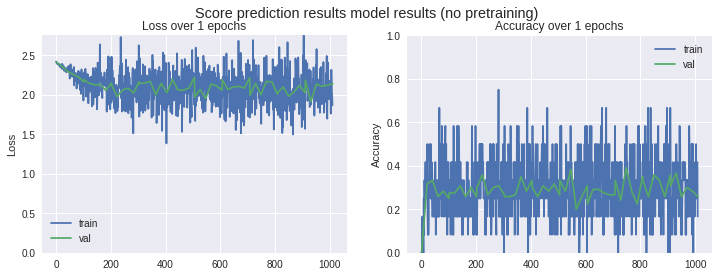

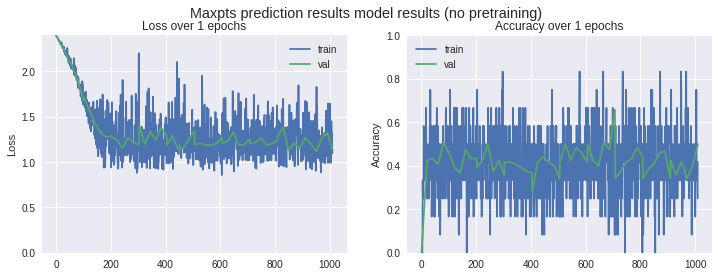

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers="ConvNet", 
      score_dict_path=None, 
      maxpts_dict_path=None, val_freq=20, 
      num_epochs=10, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

### 1 epoch, best score model, best full dataset maxpts model

Validation 1/3: score loss 0.1105, acc 1.0000; maxpts_loss 0.1278, acc 0.9583: 100%|██████████| 10/10 [00:12<00:00,  1.12s/it]
Epoch 0/1: score loss 0.0714, acc 1.0000; maxpts_loss 0.0094, acc 1.0000:  11%|█         | 11/100 [00:27<02:15,  1.52s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 2/3: score loss 0.1222, acc 0.9917; maxpts_loss 0.1075, acc 0.9750: 100%|██████████| 10/10 [00:11<00:00,  1.07s/it]
Validation 3/3: score loss 0.0974, acc 0.9917; maxpts_loss 0.0433, acc 0.9833: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]



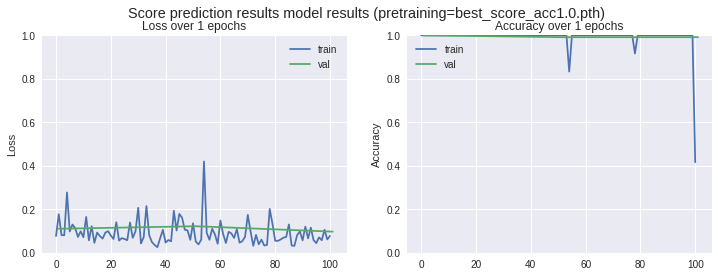

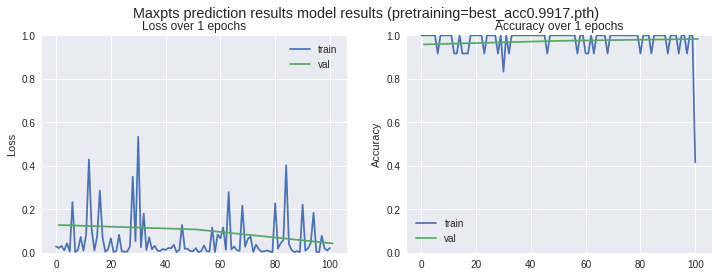

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
      score_dict_path='best_score_acc1.0.pth', 
      maxpts_dict_path='best_acc0.9917.pth', val_freq=50, 
      num_epochs=1, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

### 1 epoch, best full dataset maxpts model for both

Validation 1/3: score loss 4.4464, acc 0.4500; maxpts_loss 0.0855, acc 0.9750: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
Validation 2/3: score loss 2.4034, acc 0.4667; maxpts_loss 0.0768, acc 0.9750: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]
Epoch 0/1: score loss 2.2191, acc 0.5000; maxpts_loss 0.0498, acc 1.0000:  53%|█████▎    | 53/100 [01:34<02:54,  3.71s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 3/3: score loss 1.9755, acc 0.5167; maxpts_loss 0.0816, acc 0.9750: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]



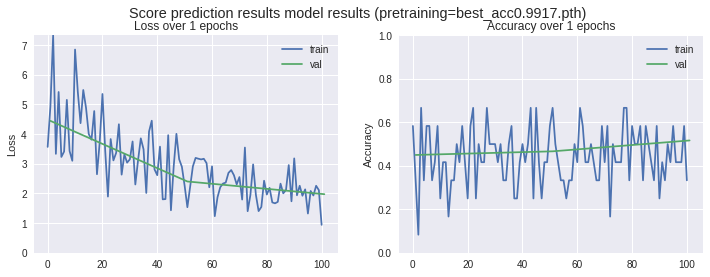

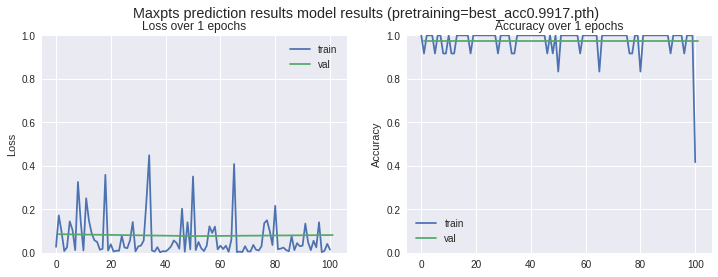

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
      score_dict_path='best_acc0.9917.pth', 
      maxpts_dict_path='best_acc0.9917.pth', val_freq=50, 
      num_epochs=1, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

### 1 epoch, swapped best score and acc models

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
      score_dict_path='best_maxpts_acc1.0.pth', 
      maxpts_dict_path='best_score_acc1.0.pth', val_freq=50, 
      num_epochs=10, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

Validation 1/3: score loss 5.2618, acc 0.2500; maxpts_loss 3.8894, acc 0.2500:  10%|█         | 1/10 [00:01<00:09,  1.03s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 1/3: score loss 5.0006, acc 0.3917; maxpts_loss 3.3636, acc 0.3917: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
Validation 2/3: score loss 2.6439, acc 0.4917; maxpts_loss 0.7029, acc 0.7583: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
Validation 3/3: score loss 2.1207, acc 0.4750; maxpts_loss 0.2684, acc 0.9583: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Validation 1/3: score loss 2.1682, acc 0.5083; maxpts_loss 0.4074, acc 0.9083: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]
Validation 2/3: score loss 1.9724, acc 0.4750; maxpts_loss 0.3686, acc 0.9250: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
Validation 3/3: score loss 1.3795, acc 0.

KeyboardInterrupt: ignored

### 1 epoch, best score and acc models

Validation 1/3: score loss 0.1075, acc 1.0000; maxpts_loss 0.0461, acc 0.9917: 100%|██████████| 10/10 [00:12<00:00,  1.19s/it]
Validation 2/3: score loss 0.0794, acc 1.0000; maxpts_loss 0.0160, acc 1.0000: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
Validation 3/3: score loss 0.0936, acc 1.0000; maxpts_loss 0.0402, acc 0.9833: 100%|██████████| 10/10 [00:11<00:00,  1.09s/it]



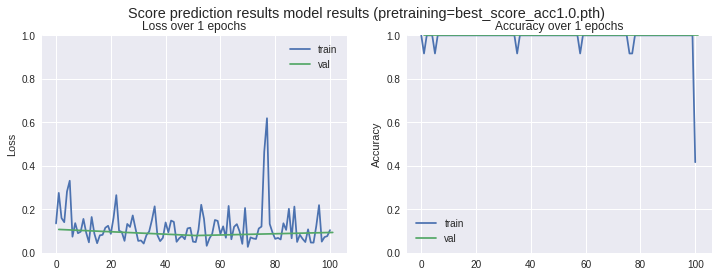

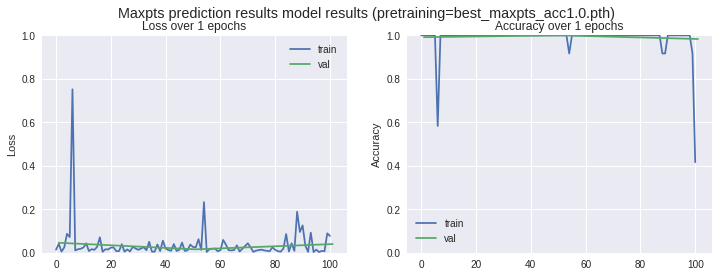

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
      score_dict_path='best_score_acc1.0.pth', 
      maxpts_dict_path='best_maxpts_acc1.0.pth', val_freq=50, 
      num_epochs=1, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

### No pretraining, 10 epochs

Validation 1/3: score loss 3.0574, acc 0.1333; maxpts_loss 2.7508, acc 0.0000: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
Validation 2/3: score loss 2.6288, acc 0.0667; maxpts_loss 1.8024, acc 0.4583: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]
Validation 3/3: score loss 2.1853, acc 0.2750; maxpts_loss 1.3809, acc 0.7083: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]

Validation 1/3: score loss 2.1588, acc 0.2583; maxpts_loss 1.4205, acc 0.7000: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
Epoch 1/15: score loss 2.2656, acc 0.1667; maxpts_loss 1.1423, acc 0.7500:  20%|██        | 20/100 [00:38<01:51,  1.40s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Validation 2/3: score loss 1.9638, acc 0.4167; maxpts_loss 1.0248, acc 0.7500: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
Validation 3/3: score loss 1.7369, acc 0.50

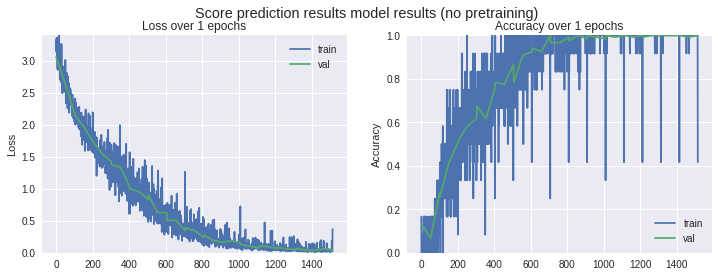

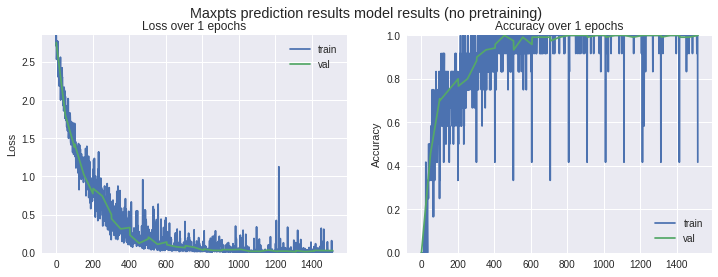

In [0]:
scope(H=64, W=128, batch_size=12, val_split=0.1, model_layers=[3,4,6,3], 
      score_dict_path=None, maxpts_dict_path=None, val_freq=50, 
      num_epochs=15, best_score=0.8, best_maxpts=0.8, predict_scores=True,
      cutoff_length=10000)

In [0]:
def count_wrong(score_path, maxpts_path, dataset, cutoff):
    
    score_model = load_resnet(64, 128, [3,4,6,3], score_path)
    maxpts_model = load_resnet(64, 128, [3,4,6,3], maxpts_path)
    batch_size = 1
    
    got_correct = set()
    got_wrong = set()

    loader = DataLoader(dataset, batch_size=batch_size)
    loop = tqdm(total=len(dataset), position=0, leave=True)

    for batch, (pages, true_score, true_max) in enumerate(loader):

        x, y_truth = pages.cuda(), true_score.cuda().long()
        y_hat = score_model(x)
        
        shifted = torch.exp(y_hat - torch.max(y_hat))
        probs = shifted/torch.sum(shifted)
        
        predicted = torch.argmax(y_hat)
        
        if predicted == y_truth:
            got_correct.add(probs[0][predicted])
        else:
            got_wrong.add(probs[0][predicted])
            
        loop.set_description("Batch {}/{}".format(batch, len(dataset)))
        loop.update(1)
            
    return got_correct, got_wrong

In [0]:
import gc
gc.collect()

21845

In [0]:
small_data = Labeled112Dataset(height=64, width=128, score_labeling=True)
#big_data = Labeled112Dataset(height=64, width=128, score_labeling=False)

root =  /content/gdrive/My Drive/CS 501R/Final Project/Score Labeling/


In [0]:
got_correct, got_wrong = count_wrong('best_score_acc1.0.pth', 
                                     'best_maxpts_acc1.0.pth', small_data, 0)

Batch 462/1205:  38%|███▊      | 463/1205 [06:42<08:55,  1.39it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  if "transparency" in self.info and \
Batch 1204/1205: 100%|██████████| 1205/1205 [15:43<00:00,  1.72it/s]

In [0]:
print(len(got_correct))
print(len(got_wrong))

359
846


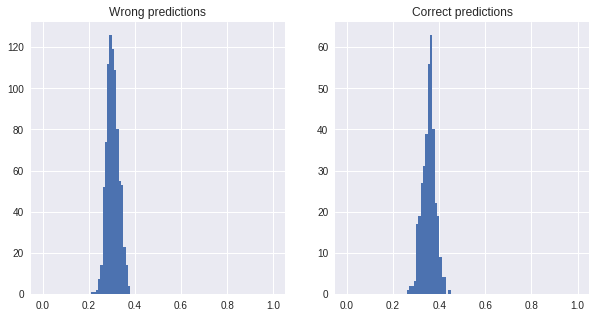

In [0]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

wrong = []
correct = []
for thing in got_wrong:
    wrong.append(thing.cpu().detach().numpy())
for thing in got_correct:
    correct.append(thing.cpu().detach().numpy())

ax1.hist(np.array(wrong), range=(0,1),bins=100)
ax1.set_title("Wrong predictions")

ax2.hist(np.array(correct), range=(0,1),bins=100)
ax2.set_title("Correct predictions")

plt.show()

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
years_count = defaultdict(int)
for p_hash, p in db.all_papers.items():
    if p.year != "None":
        years_count[p.year] += 1
        
xvals = np.array(sorted(years_count.keys()))
x_pos = xvals - xvals[0] + 1
yvals = np.array([years_count[xvals[i]] for i in range(len(xvals))])
dist = np.cumsum(yvals)

ax11.bar(x_pos, yvals, align='center')
ax11.tick_params(axis='x', rotation=45)
tickvals = np.concatenate((x_pos[:4],x_pos[8:9],x_pos[14::17]))
ticklabels = np.concatenate((xvals[:4],xvals[8:9],xvals[14::17]))
ax11.set_xticks(tickvals)
ax11.set_xticklabels(ticklabels)
ax11.set_xlabel("Publication Year")
ax11.set_ylabel("Number of Papers in Database")
ax11.set_title("All papers in database")